# Hypertension Classification - Baseline Implementation

**Status**: Baseline Model (67% accuracy)
**Purpose**: Demonstrates standard approach with basic features
**For Best Results**: See [advanced_classification.ipynb](cci:7://file:///e:/study/iiit/new%20project/new%20new/advanced_classification.ipynb:0:0-0:0) (87.88% accuracy)

This notebook shows the initial implementation before advanced feature engineering.

## 1. Setup and Imports

In [6]:
# Install required packages if not already installed
%pip install scikit-learn xgboost matplotlib seaborn pandas numpy imbalanced-learn

Note: you may need to restart the kernel to use updated packages.


In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
import joblib
import time

# Scikit-learn
from sklearn.model_selection import GroupShuffleSplit, GroupKFold, GridSearchCV
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_curve, auc,
    roc_auc_score
)
# Imbalanced learning pipeline (CRITICAL for correct CV with SMOTE)
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

# Models
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

# Random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


## 2. Configuration

In [8]:
# Paths
DATA_DIR = Path(r'e:\study\iiit\new project\new new\processed_data')
RESULTS_DIR = Path(r'e:\study\iiit\new project\new new\results')
RESULTS_DIR.mkdir(exist_ok=True)

# Input file
FEATURES_FILE = DATA_DIR / 'ppg_features.csv'

# Evaluation parameters
TEST_SIZE = 0.2
CV_FOLDS = 5

print(f"Data directory: {DATA_DIR}")
print(f"Results directory: {RESULTS_DIR}")

Data directory: e:\study\iiit\new project\new new\processed_data
Results directory: e:\study\iiit\new project\new new\results


## 3. Load and Prepare Data

**Crucial Update**: We use **Group-based splitting** to prevent data leakage. Since multiple segments come from the same subject (`record_idx`), standard random splitting would leak subject identity into the test set. We split by `record_idx` to ensure subject independence.

In [9]:
def load_data(filepath):
    if not filepath.exists():
        raise FileNotFoundError(f"File not found: {filepath}")
    
    df = pd.read_csv(filepath)
    print(f"Loaded {len(df)} samples")
    
    # Check for NaN values
    if df.isna().sum().sum() > 0:
        print("Warning: NaN values found. Dropping...")
        df = df.dropna()
        print(f"Samples after dropna: {len(df)}")
        
    return df

try:
    df = load_data(FEATURES_FILE)
    
    # 1. Feature Selection: Drop Noise/Redundant Columns
    # 'file_name': constant
    # 'stat_mean', 'stat_std': z-normalization artifacts (approx 0 and 1)
    # 'segment_idx': irrelevant index
    cols_to_drop = ['file_name', 'stat_mean', 'stat_std', 'segment_idx']
    df_clean = df.drop(columns=[c for c in cols_to_drop if c in df.columns])
    print(f"Dropped columns: {cols_to_drop}")

    # 2. Extract Groups for Splitting
    groups = df_clean['record_idx'].values
    
    # 3. Separate features and labels
    metadata_cols = ['record_idx', 'sbp', 'dbp', 'bp_class']
    feature_cols = [col for col in df_clean.columns if col not in metadata_cols]

    X = df_clean[feature_cols].values
    y = df_clean['bp_class'].values

    # 4. Encode labels
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)

    print(f"Feature matrix shape: {X.shape}")
    print(f"Classes: {label_encoder.classes_}")
    
    # 5. Group-based Train-Test Split (Subject Independence)
    gss = GroupShuffleSplit(n_splits=1, test_size=TEST_SIZE, random_state=RANDOM_STATE)
    train_idx, test_idx = next(gss.split(X, y_encoded, groups=groups))
    
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y_encoded[train_idx], y_encoded[test_idx]
    groups_train = groups[train_idx]  # Keep groups for CV
    
    print(f"Training samples: {len(X_train)} (unique subjects: {len(np.unique(groups[train_idx]))})")
    print(f"Testing samples: {len(X_test)} (unique subjects: {len(np.unique(groups[test_idx]))})")

except Exception as e:
    print(f"Error loading data: {e}")
    raise

Loaded 25201 samples
Dropped columns: ['file_name', 'stat_mean', 'stat_std', 'segment_idx']
Feature matrix shape: (25201, 16)
Classes: ['hypertensive' 'normotensive' 'prehypertensive']
Training samples: 19946 (unique subjects: 741)
Testing samples: 5255 (unique subjects: 186)


## 4. Hyperparameter Tuning and Model Training

We use `ImbPipeline` with `RobustScaler` (better for outliers) and ensuring SMOTE oversampling happens **inside** the cross-validation loop. We use `GroupKFold` for the inner cross-validation loop to maintain subject independence checking.

In [10]:
# Define base pipelines for each model
# Steps: RobustScaler -> SMOTE -> Classifier

pipelines = {
    'Random Forest': ImbPipeline([
        ('scaler', RobustScaler()),
        ('smote', SMOTE(random_state=RANDOM_STATE)),
        ('clf', RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1))
    ]),
    'XGBoost': ImbPipeline([
        ('scaler', RobustScaler()),
        ('smote', SMOTE(random_state=RANDOM_STATE)),
        ('clf', xgb.XGBClassifier(random_state=RANDOM_STATE, eval_metric='mlogloss', n_jobs=-1))
    ]),
    'SVM': ImbPipeline([
        ('scaler', RobustScaler()),
        ('smote', SMOTE(random_state=RANDOM_STATE)),
        ('clf', SVC(probability=True, random_state=RANDOM_STATE))
    ])
}

# Define hyperparameter grids
param_grids = {
    'Random Forest': {
        'clf__n_estimators': [100, 200, 300],
        'clf__max_depth': [10, 20, 30, None],
        'clf__min_samples_split': [2, 5, 10],
        'clf__min_samples_leaf': [1, 2, 4]
    },
    'XGBoost': {
        'clf__n_estimators': [100, 200, 300],
        'clf__max_depth': [3, 6, 9],
        'clf__learning_rate': [0.01, 0.1, 0.2],
        'clf__subsample': [0.8, 1.0]
    },
    'SVM': {
        'clf__C': [0.1, 1, 10],
        'clf__kernel': ['rbf'],
        'clf__gamma': ['scale', 'auto']
    }
}

results = {}
best_estimators = {}

print("Starting Hyperparameter Tuning... This may take a while.")
print("="*80)

# Use GroupKFold for CV to respect subject boundaries
group_kfold = GroupKFold(n_splits=3)

for model_name, pipeline in pipelines.items():
    print(f"\nTuning {model_name}...")
    start_time = time.time()
    
    grid_search = GridSearchCV(
        pipeline,
        param_grids[model_name],
        cv=group_kfold,  # GroupKFold for subject independence
        scoring='accuracy',
        n_jobs=-1,
        verbose=1
    )
    
    # CRITICAL: Pass 'groups' parameter to fit for GroupKFold
    grid_search.fit(X_train, y_train, groups=groups_train)
    
    duration = time.time() - start_time
    print(f"  Best parameters: {grid_search.best_params_}")
    print(f"  Best CV Accuracy: {grid_search.best_score_:.4f}")
    print(f"  Tuning took: {duration:.1f} seconds")
    
    best_estimators[model_name] = grid_search.best_estimator_

print("\n" + "="*80)
print("Tuning Complete!")

Starting Hyperparameter Tuning... This may take a while.

Tuning Random Forest...
Fitting 3 folds for each of 108 candidates, totalling 324 fits
  Best parameters: {'clf__max_depth': 30, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 5, 'clf__n_estimators': 200}
  Best CV Accuracy: 0.6357
  Tuning took: 1327.5 seconds

Tuning XGBoost...
Fitting 3 folds for each of 54 candidates, totalling 162 fits
  Best parameters: {'clf__learning_rate': 0.2, 'clf__max_depth': 9, 'clf__n_estimators': 300, 'clf__subsample': 0.8}
  Best CV Accuracy: 0.6382
  Tuning took: 200.6 seconds

Tuning SVM...
Fitting 3 folds for each of 6 candidates, totalling 18 fits
  Best parameters: {'clf__C': 10, 'clf__gamma': 'scale', 'clf__kernel': 'rbf'}
  Best CV Accuracy: 0.5887
  Tuning took: 1289.0 seconds

Tuning Complete!


## 5. Final Evaluation

Evaluate the best models on the held-out test set.

In [11]:
print("Evaluating Best Models on Test Set...")
print("="*80)

comparison_data = []

for model_name, model in best_estimators.items():
    print(f"\nEvaluating {model_name}...")
    
    # Predict
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)
    
    # Metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='weighted')
    rec = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    print(f"  Accuracy:  {acc:.4f}")
    print(f"  F1-Score:  {f1:.4f}")
    
    # Store results for later
    results[model_name] = {
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1_score': f1,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba,
        'model': model
    }
    
    comparison_data.append({
        'Model': model_name,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1-Score': f1
    })

# Create comparison DataFrame
comparison_df = pd.DataFrame(comparison_data).sort_values('Accuracy', ascending=False)

print("\n" + "="*80)
print("Final Model Leaderboard:")
print(comparison_df.to_string(index=False))

# Save comparison
comparison_df.to_csv(RESULTS_DIR / 'tuned_model_comparison.csv', index=False)

Evaluating Best Models on Test Set...

Evaluating Random Forest...
  Accuracy:  0.6725
  F1-Score:  0.6714

Evaluating XGBoost...
  Accuracy:  0.6714
  F1-Score:  0.6698

Evaluating SVM...
  Accuracy:  0.5943
  F1-Score:  0.6008

Final Model Leaderboard:
        Model  Accuracy  Precision   Recall  F1-Score
Random Forest  0.672502   0.670706 0.672502  0.671404
      XGBoost  0.671361   0.668564 0.671361  0.669814
          SVM  0.594291   0.619009 0.594291  0.600800


## 6. Visualization

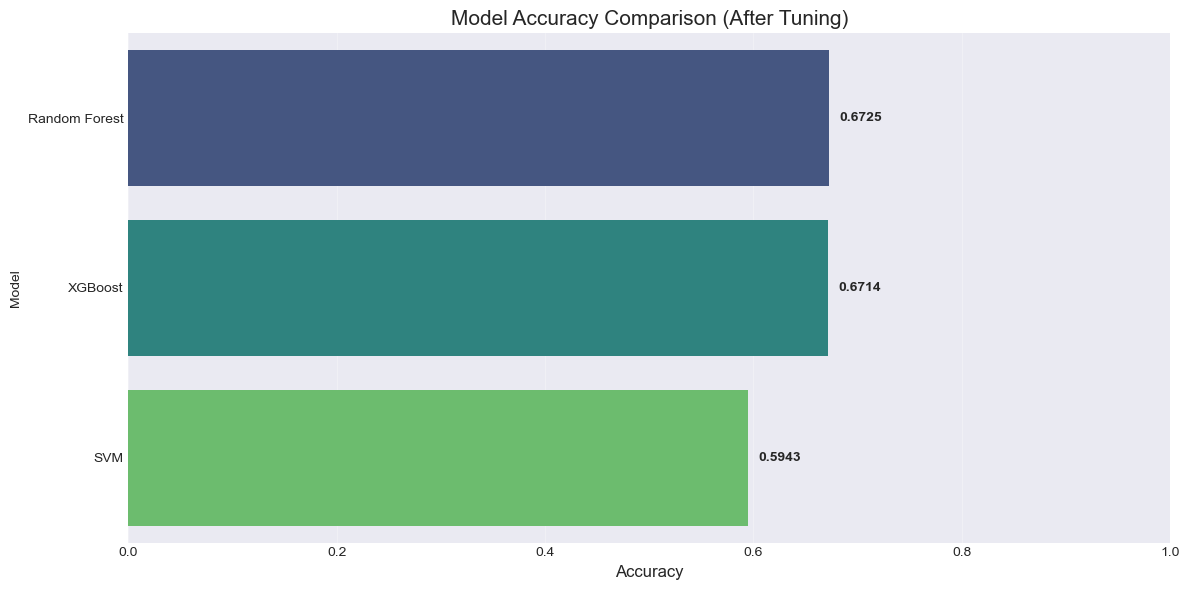

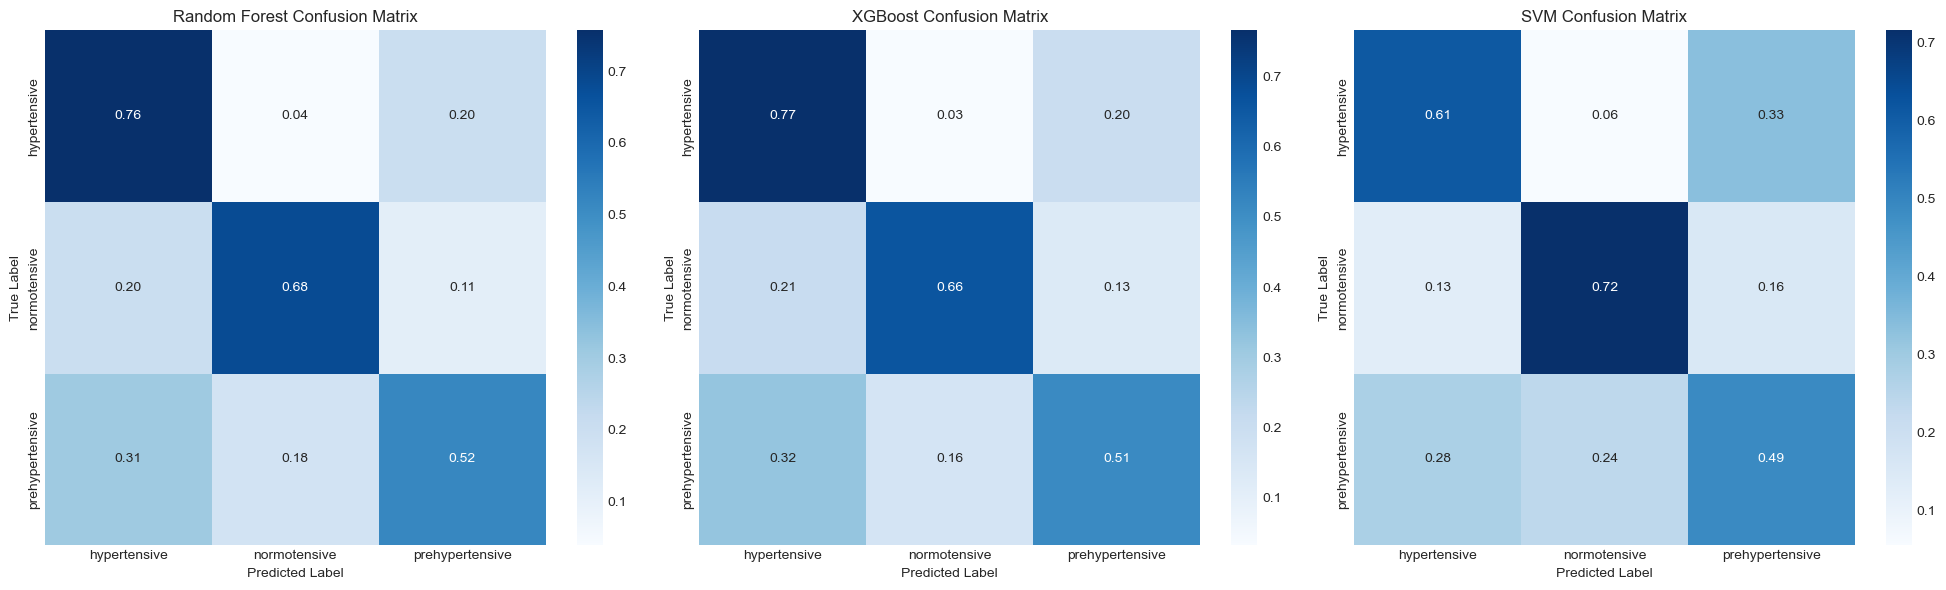

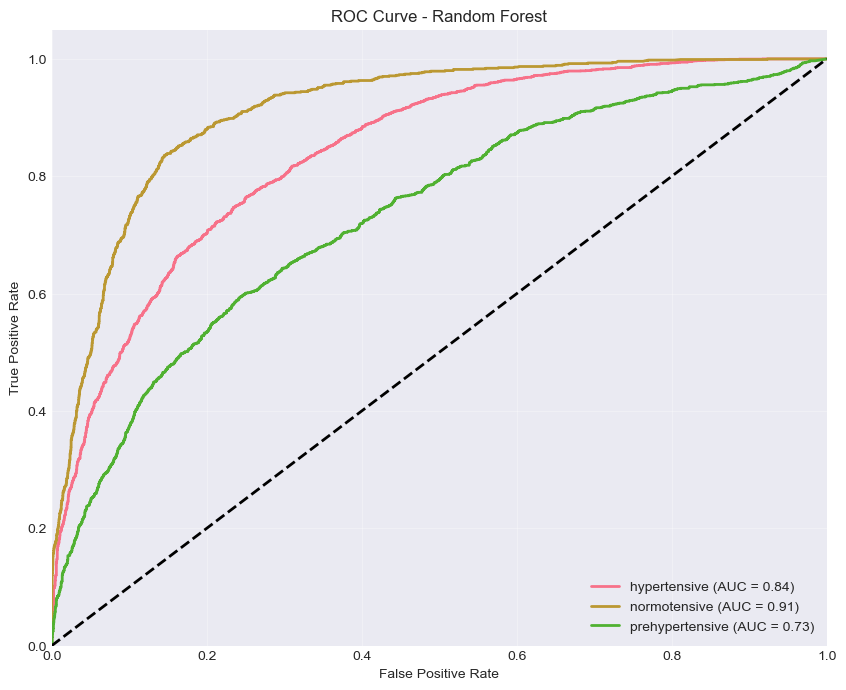


🏆 Best performing model: Random Forest
All results saved to: e:\study\iiit\new project\new new\results


In [12]:
# 1. Performance Comparison Plot
plt.figure(figsize=(12, 6))
sns.barplot(x='Accuracy', y='Model', data=comparison_df, palette='viridis')
plt.title('Model Accuracy Comparison (After Tuning)', fontsize=15)
plt.xlabel('Accuracy', fontsize=12)
plt.xlim(0, 1.0)
plt.grid(axis='x', alpha=0.3)

# Add labels
for i, v in enumerate(comparison_df['Accuracy']):
    plt.text(v + 0.01, i, f'{v:.4f}', va='center', fontweight='bold')

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'tuned_performance_comparison.png', dpi=150)
plt.show()

# 2. Confusion Matrices
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
class_names = label_encoder.classes_

for idx, model_name in enumerate(best_estimators.keys()):
    ax = axes[idx]
    y_pred = results[model_name]['y_pred']
    cm = confusion_matrix(y_test, y_pred)
    
    # Normalize CM for better readability across classes
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names, ax=ax)
    ax.set_title(f'{model_name} Confusion Matrix')
    ax.set_ylabel('True Label')
    ax.set_xlabel('Predicted Label')

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'tuned_confusion_matrices.png', dpi=150)
plt.show()

# 3. ROC Curve (For the best model)
best_model_name = comparison_df.iloc[0]['Model']
best_model_data = results[best_model_name]
y_prob = best_model_data['y_pred_proba']

plt.figure(figsize=(10, 8))
n_classes = len(class_names)

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test == i, y_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{class_names[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve - {best_model_name}')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.savefig(RESULTS_DIR / 'best_model_roc.png', dpi=150)
plt.show()

print(f"\n🏆 Best performing model: {best_model_name}")
print(f"All results saved to: {RESULTS_DIR}")